In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo
from datetime import datetime, timedelta
import alpaca_trade_api as tradeapi
import warnings
warnings.filterwarnings('ignore')

# Set up Plotly for Jupyter
pyo.init_notebook_mode(connected=True)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Data Fetching


BTC PRICES- ALPACA
BTC DOMINANCE- COINGECKO
MACRO FEATURES - FRED

In [2]:
# Exact code from live_trader.py for data fetching
import json
import sys
import time
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame

# Load API credentials from config.json (same as live_trader.py)
try:
    with open('config.json', 'r') as f:
        config = json.load(f)
        api_key = config.get('ALPACA_API_KEY')
        api_secret = config.get('ALPACA_SECRET_KEY')
        print("Successfully loaded API credentials from config.json")
except FileNotFoundError:
    print("Error: config.json not found. Please ensure the file exists in the project root.")
    sys.exit(1)

# Modified get_historical_data method for daily data
def get_historical_data(symbol, timeframe='1Day', start_date='2010-01-01', end_date=None):
    """Get historical bar data from Alpaca with connection retry"""
    max_retries = 5
    initial_retry_delay = 5
    
    for attempt in range(max_retries):
        try:
            # Set default dates if not provided
            if end_date is None:
                end_dt = datetime.now(pytz.UTC)
            else:
                end_dt = end_date
                
            if start_date is None:
                # For daily data, get last 365 days (1 year) of data
                start_dt = end_dt - timedelta(days=365)
            else:
                start_dt = start_date
            
            # Check if symbol is crypto or equity
            is_crypto = '/' in symbol or symbol.endswith('USD')
            
            if is_crypto:
                # Initialize crypto client
                data_client = CryptoHistoricalDataClient()
                
                # Format crypto symbol (ensure it has the correct format)
                if not '/' in symbol:
                    formatted_symbol = f"{symbol[:-3]}/USD"  # Convert BTCUSD to BTC/USD
                else:
                    formatted_symbol = symbol
                    
                print(f"Fetching {timeframe} bars for {formatted_symbol}")
                
                # Create request parameters for crypto
                request_params = CryptoBarsRequest(
                    symbol_or_symbols=[formatted_symbol],
                    timeframe=TimeFrame.Day,  # Changed to daily data
                    start=start_dt,
                    end=end_dt
                )
                
                # Get crypto bars using data_client
                bars = data_client.get_crypto_bars(request_params)
                df = bars.df
                
                # If multiple symbols are returned, select only our symbol
                if isinstance(df.index, pd.MultiIndex):
                    df = df.xs(formatted_symbol)
            else:
                # This would be for equity data - not implemented in this example
                print("Equity data not implemented in this notebook")
                return pd.DataFrame()
            
            if df.empty:
                raise Exception(f"No data received for {symbol}")
            
            # Convert to OHLCV format and ensure DataFrame
            df = pd.DataFrame(df)
            
            # Ensure column names are correct
            df = df.rename(columns={
                'open': 'Open',
                'high': 'High',
                'low': 'Low',
                'close': 'Close',
                'volume': 'Volume',
                'trade_count': 'trade_count',
                'vwap': 'vwap'
            })
            
            # Resample to daily bars if needed
            if timeframe != '1Day':
                df = df.resample('1D').agg({
                    'Open': 'first',
                    'High': 'max',
                    'Low': 'min',
                    'Close': 'last',
                    'Volume': 'sum'
                }).dropna()
            
            print(f"Retrieved {len(df)} bars for {symbol}")
            return df
            
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"Error fetching data (attempt {attempt + 1}/{max_retries}): {str(e)}")
                print(f"Retrying in {initial_retry_delay} seconds...")
                time.sleep(initial_retry_delay)
            else:
                print(f"Failed to fetch data after {max_retries} attempts: {str(e)}")
                return pd.DataFrame()

# Use daily data parameters
symbol = 'BTC/USD'
# Set start_date to 2000-01-01 and end_date to today
start_date = datetime(2000, 1, 1, tzinfo=pytz.UTC)
end_date = datetime.now(pytz.UTC)

print(f"Fetching daily data for {symbol} from {start_date.date()} to {end_date.date()}")

# Call the function for daily data
df = get_historical_data(symbol, timeframe='1Day', start_date=start_date, end_date=end_date)

if not df.empty:
    # Prepare data for plotting (convert column names to lowercase for consistency)
    barset = df.copy()
    barset = barset.rename(columns={
        'Open': 'open',
        'High': 'high', 
        'Low': 'low',
        'Close': 'close',
        'Volume': 'volume'
    })
    
    # Reset index to make timestamp a column
    barset.reset_index(inplace=True)
    # Ensure 'timestamp' column is present and correct
    if 'timestamp' not in barset.columns:
        barset['timestamp'] = barset['index']
    barset['timestamp'] = pd.to_datetime(barset['timestamp'])
    
    # Calculate additional technical indicators
    barset['daily_return'] = barset['close'].pct_change()
    barset['volatility'] = barset['daily_return'].rolling(window=20).std()
    barset['sma_20'] = barset['close'].rolling(window=20).mean()
    barset['sma_50'] = barset['close'].rolling(window=50).mean()
    
    # Calculate RSI (Relative Strength Index)
    delta = barset['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    barset['rsi'] = 100 - (100 / (1 + rs))
    
    print(f"✅ Successfully processed {len(barset)} bars for {symbol}")
    print(f"Data range: {barset['timestamp'].min()} to {barset['timestamp'].max()}")
    print("\nDataset preview:")
    print(barset.head())
else:
    print("❌ No data received, creating empty DataFrame")
    barset = pd.DataFrame()


Successfully loaded API credentials from config.json
Fetching daily data for BTC/USD from 2000-01-01 to 2025-08-12
Fetching 1Day bars for BTC/USD
Retrieved 1685 bars for BTC/USD
✅ Successfully processed 1685 bars for BTC/USD
Data range: 2021-01-01 00:00:00+00:00 to 2025-08-12 00:00:00+00:00

Dataset preview:
                  timestamp      open      high       low     close  \
0 2021-01-01 00:00:00+00:00  29255.71  29680.75  28707.56  29418.72   
1 2021-01-02 00:00:00+00:00  29417.27  33338.68  29050.00  32218.38   
2 2021-01-03 00:00:00+00:00  32200.39  34812.93  32010.68  33111.99   
3 2021-01-04 00:00:00+00:00  33086.17  33655.01  27900.00  32025.23   
4 2021-01-05 00:00:00+00:00  32025.23  34500.00  29927.55  34036.08   

        volume  trade_count          vwap  daily_return  volatility  sma_20  \
0   619.419752      21854.0  29282.583701           NaN         NaN     NaN   
1  1945.276677      54930.0  31385.534621      0.095166         NaN     NaN   
2  1926.666883      59204.

In [3]:
# Create comprehensive interactive plots for financial analysis using Plotly

if barset is None:
    print("❌ No data available. Please check your symbol and timeframe.")
else:
    print(f"✅ Data available! Creating plots for {len(barset)} data points...")
    
    # Forward fill to remove NaN values
    print("Applying forward fill to remove NaN values...")
    barset = barset.fillna(method='ffill')
    print(f"Data cleaned. Remaining NaN values: {barset.isnull().sum().sum()}")
    
    # 1. Price Chart with Moving Averages and Volume
    fig_price = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.1,
        subplot_titles=(f'{symbol} - Price Chart with Moving Averages', 'Trading Volume'),
        row_heights=[0.7, 0.3]
    )

    # Add price and moving averages
    fig_price.add_trace(
        go.Scatter(x=barset['timestamp'], y=barset['close'], 
                  name='Close Price', line=dict(color='blue', width=2)),
        row=1, col=1
    )
    fig_price.add_trace(
        go.Scatter(x=barset['timestamp'], y=barset['sma_20'], 
                  name='SMA 20', line=dict(color='orange', width=1)),
        row=1, col=1
    )
    fig_price.add_trace(
        go.Scatter(x=barset['timestamp'], y=barset['sma_50'], 
                  name='SMA 50', line=dict(color='red', width=1)),
        row=1, col=1
    )

    # Add volume
    fig_price.add_trace(
        go.Bar(x=barset['timestamp'], y=barset['volume'], 
               name='Volume', marker_color='lightblue', opacity=0.7),
        row=2, col=1
    )

    fig_price.update_layout(
        title=f'{symbol} - Stock Analysis Dashboard',
        xaxis_title='Date',
        yaxis_title='Price ($)',
        height=600,
        showlegend=True
    )
    fig_price.update_xaxes(title_text="Date", row=2, col=1)
    fig_price.update_yaxes(title_text="Volume", row=2, col=1)

    fig_price.show()

    # 2. Daily Returns Distribution
    returns_clean = barset['daily_return'].dropna()
    fig_returns = go.Figure()

    fig_returns.add_trace(go.Histogram(
        x=returns_clean,
        nbinsx=50,
        name='Daily Returns',
        marker_color='green',
        opacity=0.7
    ))

    fig_returns.add_vline(
        x=returns_clean.mean(),
        line_dash="dash",
        line_color="red",
        annotation_text=f"Mean: {returns_clean.mean():.4f}"
    )

    fig_returns.update_layout(
        title=f'{symbol} - Daily Returns Distribution',
        xaxis_title='Daily Return',
        yaxis_title='Frequency',
        height=400
    )
    fig_returns.show()

    # 2b. Plot daily returns as a time series
    fig_returns_ts = go.Figure()
    fig_returns_ts.add_trace(go.Scatter(
        x=barset['timestamp'],
        y=barset['daily_return'],
        mode='lines',
        name='Daily Return',
        line=dict(color='green', width=1)
    ))
    fig_returns_ts.add_hline(y=0, line_dash="dash", line_color="gray")
    fig_returns_ts.update_layout(
        title=f'{symbol} - Daily Returns Over Time',
        xaxis_title='Date',
        yaxis_title='Daily Return',
        height=400
    )
    fig_returns_ts.show()

    # 3. RSI Chart
    fig_rsi = go.Figure()

    fig_rsi.add_trace(go.Scatter(
        x=barset['timestamp'], 
        y=barset['rsi'],
        mode='lines',
        name='RSI',
        line=dict(color='purple', width=2)
    ))

    fig_rsi.add_hline(y=70, line_dash="dash", line_color="red", 
                      annotation_text="Overbought (70)")
    fig_rsi.add_hline(y=30, line_dash="dash", line_color="green", 
                      annotation_text="Oversold (30)")

    fig_rsi.update_layout(
        title=f'{symbol} - RSI (Relative Strength Index)',
        xaxis_title='Date',
        yaxis_title='RSI',
        yaxis=dict(range=[0, 100]),
        height=400
    )
    fig_rsi.show()

    # 4. Volatility Chart
    fig_vol = go.Figure()

    fig_vol.add_trace(go.Scatter(
        x=barset['timestamp'], 
        y=barset['volatility'],
        mode='lines',
        name='20-Day Rolling Volatility',
        line=dict(color='red', width=2),
        fill='tonexty'
    ))

    fig_vol.update_layout(
        title=f'{symbol} - 20-Day Rolling Volatility',
        xaxis_title='Date',
        yaxis_title='Volatility',
        height=400
    )
    fig_vol.show()

    # 5. Price vs Volume Scatter Plot
    fig_scatter = px.scatter(
        barset, 
        x='volume', 
        y='close',
        color='daily_return',
        size='volume',
        hover_data=['timestamp'],
        title=f'{symbol} - Price vs Volume Relationship',
        color_continuous_scale='RdYlBu'
    )

    fig_scatter.update_layout(
        xaxis_title='Volume',
        yaxis_title='Close Price ($)',
        height=500
    )
    fig_scatter.show()

    # 6. Correlation Heatmap
    correlation_features = ['close', 'volume', 'daily_return', 'volatility', 'rsi']
    correlation_matrix = barset[correlation_features].corr()

    fig_corr = go.Figure(data=go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.columns,
        colorscale='RdBu',
        zmid=0,
        text=correlation_matrix.round(3).values,
        texttemplate="%{text}",
        textfont={"size": 12},
        hoverongaps=False
    ))

    fig_corr.update_layout(
        title=f'{symbol} - Feature Correlation Heatmap',
        height=500
    )
    fig_corr.show()

    # 7. Candlestick Chart (Bonus interactive chart)
    fig_candlestick = go.Figure(data=go.Candlestick(
        x=barset['timestamp'],
        open=barset['open'],
        high=barset['high'],
        low=barset['low'],
        close=barset['close'],
        name='OHLC'
    ))

    fig_candlestick.update_layout(
        title=f'{symbol} - Candlestick Chart',
        xaxis_title='Date',
        yaxis_title='Price ($)',
        height=500,
        xaxis_rangeslider_visible=False
    )
    fig_candlestick.show()

    # Statistical Summary
    print("\n" + "="*50)
    print("STATISTICAL SUMMARY")
    print("="*50)

    # Basic statistics
    print(f"\n{symbol} - Key Statistics:")
    print(f"Current Price: ${barset['close'].iloc[-1]:.2f}")
    print(f"52-Week High: ${barset['close'].max():.2f}")
    print(f"52-Week Low: ${barset['close'].min():.2f}")
    print(f"Average Daily Return: {barset['daily_return'].mean():.4f} ({barset['daily_return'].mean()*100:.2f}%)")
    print(f"Volatility (Std Dev): {barset['daily_return'].std():.4f} ({barset['daily_return'].std()*100:.2f}%)")
    print(f"Average Volume: {barset['volume'].mean():,.0f}")
    print("\nCorrelation Matrix:")
    print(correlation_matrix.round(3))


✅ Data available! Creating plots for 1685 data points...
Applying forward fill to remove NaN values...
Data cleaned. Remaining NaN values: 102



STATISTICAL SUMMARY

BTC/USD - Key Statistics:
Current Price: $120008.96
52-Week High: $120051.70
52-Week Low: $15756.60
Average Daily Return: 0.0013 (0.13%)
Volatility (Std Dev): 0.0315 (3.15%)
Average Volume: 1,971

Correlation Matrix:
              close  volume  daily_return  volatility    rsi
close         1.000  -0.504         0.039      -0.181  0.155
volume       -0.504   1.000        -0.017       0.103 -0.017
daily_return  0.039  -0.017         1.000       0.010  0.263
volatility   -0.181   0.103         0.010       1.000 -0.109
rsi           0.155  -0.017         0.263      -0.109  1.000


## FRED ##


In [4]:
import pandas as pd
import os
import requests

# We'll use the FRED API to access economic data directly.
# You need an API key from https://fred.stlouisfed.org/docs/api/api_key.html

FRED_API_KEY = 'b24786a45dd3d34325a8958a2e7d8d13'  # Set your FRED API key as an environment variable

def get_fred_series(series_id, api_key, start_date='2021-01-01', end_date=None):
    """
    Download a single FRED series as a pandas DataFrame.
    """
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json"
    }
    if start_date:
        params["observation_start"] = start_date
    if end_date:
        params["observation_end"] = end_date

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data["observations"])
        df["date"] = pd.to_datetime(df["date"])
        df = df[["date", "value"]]
        df.rename(columns={"value": series_id}, inplace=True)
        df[series_id] = pd.to_numeric(df[series_id], errors="coerce")
        return df
    else:
        print(f"Failed to fetch {series_id}: {response.status_code}")
        return None

# Example: Download a few common macroeconomic series from FRED
fred_series = [
    "FEDFUNDS",    # Effective Federal Funds Rate (impacts global liquidity and risk appetite)
    "CPIAUCSL",    # Consumer Price Index for All Urban Consumers (inflation, affects real returns and Fed policy)
    "UNRATE",      # Unemployment Rate (broad economic health, can influence risk-on/risk-off sentiment)
    "M2SL",        # M2 Money Stock (liquidity in the system, can affect speculative assets like crypto)
    "DTB3",        # 3-Month Treasury Bill: Secondary Market Rate (short-term risk-free rate, opportunity cost)
    "DGS10",       # 10-Year Treasury Constant Maturity Rate (benchmark for global risk assets)
    "SP500",       # S&P 500 (proxy for risk sentiment in traditional markets)
    "NASDAQCOM",   # NASDAQ Composite (tech/growth risk sentiment, often correlated with crypto)
    "VIXCLS",      # CBOE Volatility Index: VIX (market fear/volatility, can drive flows into or out of crypto)
    "RECPROUSM156N", # NBER based Recession Indicators (broad economic regime, risk appetite)
    "EXUSUK",      # U.S. / U.K. Foreign Exchange Rate (major FX moves can impact crypto as a global asset)
    "EXUSEU",      # U.S. / Euro Foreign Exchange Rate (same as above)
    "EXJPUS",      # Japan / U.S. Foreign Exchange Rate (same as above)
    "EXCAUS",      # Canada / U.S. Foreign Exchange Rate (same as above)
    "WTISPLC",     # Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma (energy prices can affect inflation and risk sentiment)
    "DCOILWTICO",  # Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma (alternative, same reason)
    "GASREGW",     # U.S. Regular All Formulations Gas Price (consumer inflation, can affect risk appetite)
    "CBBTCUSD",    # Bitcoin to US Dollar (directly relevant, actual BTC price from FRED)
    "BUSLOANS",    # Commercial and Industrial Loans, All Commercial Banks (credit conditions, risk appetite)
    "TEDRATE",     # TED Spread (banking/credit risk, can affect risk assets)
    "GS2",         # 2-Year Treasury Constant Maturity Rate (shorter-term rates, Fed policy expectations)
    "GS10",        # 10-Year Treasury Constant Maturity Rate (included for completeness, see above)
    "GS30",        # 30-Year Treasury Constant Maturity Rate (long-term rates, inflation expectations)
    "BAA10Y",      # Moody's Seasoned Baa Corporate Bond Yield Relative to Yield on 10-Year Treasury (credit risk premium)
    "AAA",         # Moody's Seasoned Aaa Corporate Bond Yield (credit conditions)
    "BAA",         # Moody's Seasoned Baa Corporate Bond Yield (credit conditions)
    # Remove duplicate "M2SL"
    "WM2NS",       # World M2 Money Stock (global liquidity, can affect crypto as a global asset)
]

if FRED_API_KEY is None:
    print("Please set your FRED_API_KEY as an environment variable to access the FRED API.")
else:
    fred_data = pd.DataFrame()
    seen_series = set()
    for series in fred_series:
        if series in seen_series:
            continue  # Skip duplicate series
        seen_series.add(series)
        df = get_fred_series(series, FRED_API_KEY)
        if df is not None:
            if fred_data.empty:
                fred_data = df.set_index("date")
            else:
                # Only join columns that are not already present
                cols_to_add = [col for col in df.columns if col not in fred_data.columns or col == "date"]
                if cols_to_add and series in cols_to_add:
                    fred_data = fred_data.join(df.set_index("date")[[series]], how="outer")
    if not fred_data.empty:
        print("Downloaded FRED data:")
    else:
        print("No FRED data was downloaded.")

fred_data = fred_data.fillna(method='ffill')
fred_data = fred_data.fillna(method='bfill')

Downloaded FRED data:


In [5]:
# Information Coefficient Analysis for FRED Economic Data + Technical Indicators
import scipy.stats as stats

def compute_information_coefficient_fred(price_data, fred_data, target_col='daily_return', lag_periods=[1, 5, 10, 20, 30]):
    """
    Compute Information Coefficient (IC) between FRED economic features + technical indicators and symbol returns.
    """
    df = price_data.copy()

    # Make sure the index is datetime and tz-naive for both dataframes
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        if df['timestamp'].dt.tz is not None:
            df['timestamp'] = df['timestamp'].dt.tz_localize(None)
        df = df.set_index('timestamp')
    else:
        if df.index.dtype == 'datetime64[ns, UTC]' or hasattr(df.index, 'tz') and df.index.tz is not None:
            df.index = df.index.tz_localize(None)

    technical_features = []

    if 'price_momentum_5' not in df.columns:
        df['price_momentum_5'] = df['close'].pct_change(5)
        technical_features.append('price_momentum_5')
    if 'price_momentum_10' not in df.columns:
        df['price_momentum_10'] = df['close'].pct_change(10)
        technical_features.append('price_momentum_10')
    if 'price_momentum_20' not in df.columns:
        df['price_momentum_20'] = df['close'].pct_change(20)
        technical_features.append('price_momentum_20')
    if 'volume_ma_5' not in df.columns:
        df['volume_ma_5'] = df['volume'].rolling(window=5).mean()
        technical_features.append('volume_ma_5')
    if 'volume_ma_10' not in df.columns:
        df['volume_ma_10'] = df['volume'].rolling(window=10).mean()
        technical_features.append('volume_ma_10')
    if 'volume_ratio' not in df.columns:
        df['volume_ratio'] = df['volume'] / df['volume'].rolling(window=20).mean()
        technical_features.append('volume_ratio')

    existing_technical = ['close', 'volume', 'volatility', 'sma_20', 'sma_50', 'rsi', 'high', 'low', 'open']
    technical_features.extend([col for col in existing_technical if col in df.columns])

    # Merge with FRED data, making sure both indices are tz-naive
    if fred_data is not None and not fred_data.empty:
        # Make sure FRED index is datetime and tz-naive
        if fred_data.index.dtype != 'datetime64[ns]':
            fred_data.index = pd.to_datetime(fred_data.index)
        if hasattr(fred_data.index, 'tz') and fred_data.index.tz is not None:
            fred_data.index = fred_data.index.tz_localize(None)

        # Now merge
        df_merged = df.merge(fred_data, left_index=True, right_index=True, how='left')

        fred_columns = [col for col in fred_data.columns if col in df_merged.columns]
        df_merged[fred_columns] = df_merged[fred_columns].fillna(method='ffill')

        print(f"✅ Merged {len(fred_columns)} FRED features with price data")
        print(f"FRED features: {fred_columns}")
    else:
        df_merged = df.copy()
        fred_columns = []
        print("⚠️ No FRED data provided, using only technical indicators")

    all_features = technical_features + fred_columns
    ic_results = []

    print(f"🔍 Testing {len(all_features)} features across {len(lag_periods)} lag periods...")

    for lag in lag_periods:
        for feature in all_features:
            if feature not in df_merged.columns:
                continue

            lagged_feature = df_merged[feature].shift(lag)
            target_values = df_merged[target_col]

            valid_mask = ~(lagged_feature.isna() | target_values.isna())
            if valid_mask.sum() < 30:
                continue

            feature_clean = lagged_feature[valid_mask]
            target_clean = target_values[valid_mask]

            ic_spearman, p_value_spearman = stats.spearmanr(feature_clean, target_clean)
            ic_pearson, p_value_pearson = stats.pearsonr(feature_clean, target_clean)

            feature_type = 'FRED' if feature in fred_columns else 'Technical'

            ic_results.append({
                'feature': feature,
                'feature_type': feature_type,
                'lag': lag,
                'ic_spearman': ic_spearman,
                'p_value_spearman': p_value_spearman,
                'ic_pearson': ic_pearson,
                'p_value_pearson': p_value_pearson,
                'n_observations': len(feature_clean),
                'significant_spearman': p_value_spearman < 0.05,
                'significant_pearson': p_value_pearson < 0.05
            })

    ic_df = pd.DataFrame(ic_results)
    return ic_df

def analyze_ic_results_fred(ic_df):
    """
    Analyze and summarize IC results for FRED + Technical features
    """
    print("="*80)
    print("INFORMATION COEFFICIENT ANALYSIS: FRED ECONOMIC DATA + TECHNICAL INDICATORS")
    print("="*80)

    total_tests = len(ic_df)
    significant_spearman = ic_df['significant_spearman'].sum()
    significant_pearson = ic_df['significant_pearson'].sum()

    print(f"\nOVERALL SUMMARY:")
    print(f"Total feature-lag combinations tested: {total_tests}")
    print(f"Significant Spearman correlations (p<0.05): {significant_spearman} ({significant_spearman/total_tests*100:.1f}%)")
    print(f"Significant Pearson correlations (p<0.05): {significant_pearson} ({significant_pearson/total_tests*100:.1f}%)")

    if 'feature_type' in ic_df.columns:
        type_summary = ic_df.groupby('feature_type').agg({
            'ic_spearman': lambda x: abs(x).mean(),
            'significant_spearman': 'mean',
            'feature': 'count'
        }).round(3)
        type_summary.columns = ['avg_abs_ic', 'pct_significant', 'count']

        print(f"\nFEATURE TYPE BREAKDOWN:")
        for ftype, row in type_summary.iterrows():
            # Use .0f for count to avoid ValueError if count is float
            print(f"  {ftype:10}: {int(row['count']):3d} tests, IC={row['avg_abs_ic']:.3f}, Significant={row['pct_significant']*100:4.1f}%")

    print(f"\nTOP 20 FEATURES BY ABSOLUTE SPEARMAN IC:")
    top_spearman = ic_df.copy()
    top_spearman['abs_ic_spearman'] = abs(top_spearman['ic_spearman'])
    top_spearman = top_spearman.nlargest(20, 'abs_ic_spearman')

    for _, row in top_spearman.iterrows():
        significance_marker = "***" if row['significant_spearman'] else ""
        feature_type_marker = f"[{row.get('feature_type', 'N/A')}]"
        print(f"  {row['feature']:25} {feature_type_marker:10} (lag={int(row['lag']):2d}): "
              f"IC={row['ic_spearman']:6.3f}, p={row['p_value_spearman']:.4f} {significance_marker}")

    print(f"\nTOP 20 FEATURES BY AVERAGE PERFORMANCE:")
    feature_summary = ic_df.groupby('feature').agg({
        'ic_spearman': lambda x: abs(x).mean(),
        'significant_spearman': 'mean',
        'n_observations': 'mean',
        'feature_type': 'first'
    }).round(3)
    feature_summary.columns = ['avg_abs_ic', 'pct_significant', 'avg_observations', 'feature_type']
    feature_summary = feature_summary.sort_values('avg_abs_ic', ascending=False)

    for feature, row in feature_summary.head(20).iterrows():
        # Use .0f for avg_observations to avoid ValueError if float
        print(f"  {feature:25} [{row['feature_type']:9}]: IC={row['avg_abs_ic']:.3f}, "
              f"Significant={row['pct_significant']*100:4.1f}%, N={int(row['avg_observations']):d}")

    print(f"\nLAG ANALYSIS (avg absolute Spearman IC by lag period):")
    lag_summary = ic_df.groupby('lag').agg({
        'ic_spearman': lambda x: abs(x).mean(),
        'significant_spearman': 'mean'
    }).round(3)
    lag_summary.columns = ['avg_abs_ic', 'pct_significant']

    for lag, row in lag_summary.iterrows():
        # Use .0f for lag to avoid ValueError if float
        print(f"  Lag {int(lag):2d}: IC={row['avg_abs_ic']:.3f}, Significant={row['pct_significant']*100:4.1f}%")

    if 'feature_type' in ic_df.columns:
        fred_features = ic_df[ic_df['feature_type'] == 'FRED']
        if not fred_features.empty:
            print(f"\n🏛️ BEST FRED ECONOMIC INDICATORS:")
            fred_top = fred_features.groupby('feature')['ic_spearman'].apply(lambda x: abs(x).mean()).sort_values(ascending=False)
            for feature, ic in fred_top.head(15).items():
                print(f"  {feature:30}: Avg |IC| = {ic:.3f}")

    return feature_summary, lag_summary

# Run IC analysis if we have data
if not barset.empty:
    print("🔍 Computing Information Coefficients for FRED + Technical Features...")

    # Forward fill data to handle NaN values
    data_clean = barset.fillna(method='ffill').fillna(method='bfill')

    # Make sure barset index is tz-naive
    if data_clean.index.dtype == 'datetime64[ns, UTC]' or hasattr(data_clean.index, 'tz') and data_clean.index.tz is not None:
        data_clean.index = data_clean.index.tz_localize(None)

    # Check if fred_data variable exists and use it
    if 'fred_data' in locals() or 'fred_data' in globals():
        print(f"📊 Using existing fred_data: {fred_data.shape[0]} rows, {fred_data.shape[1]} columns")

        # Make sure fred_data index is tz-naive
        if fred_data.index.dtype != 'datetime64[ns]':
            fred_data.index = pd.to_datetime(fred_data.index)
        if hasattr(fred_data.index, 'tz') and fred_data.index.tz is not None:
            fred_data.index = fred_data.index.tz_localize(None)

        ic_results = compute_information_coefficient_fred(
            data_clean,
            fred_data,
            target_col='daily_return',
            lag_periods=[1, 5, 10, 20, 30]
        )

        feature_perf, lag_perf = analyze_ic_results_fred(ic_results)

        print(f"\n✅ IC analysis complete! Found {len(ic_results)} feature-lag combinations.")
        print(f"IC results stored in 'ic_results' DataFrame for further analysis.")

    else:
        print("❌ fred_data variable not found. Please ensure FRED data is loaded.")

else:
    print("❌ No data available for IC analysis. Please run the data fetching cell first.")


🔍 Computing Information Coefficients for FRED + Technical Features...
📊 Using existing fred_data: 1684 rows, 27 columns
✅ Merged 27 FRED features with price data
FRED features: ['FEDFUNDS', 'CPIAUCSL', 'UNRATE', 'M2SL', 'DTB3', 'DGS10', 'SP500', 'NASDAQCOM', 'VIXCLS', 'RECPROUSM156N', 'EXUSUK', 'EXUSEU', 'EXJPUS', 'EXCAUS', 'WTISPLC', 'DCOILWTICO', 'GASREGW', 'CBBTCUSD', 'BUSLOANS', 'TEDRATE', 'GS2', 'GS10', 'GS30', 'BAA10Y', 'AAA', 'BAA', 'WM2NS']
🔍 Testing 42 features across 5 lag periods...
INFORMATION COEFFICIENT ANALYSIS: FRED ECONOMIC DATA + TECHNICAL INDICATORS

OVERALL SUMMARY:
Total feature-lag combinations tested: 210
Significant Spearman correlations (p<0.05): 1 (0.5%)
Significant Pearson correlations (p<0.05): 17 (8.1%)

FEATURE TYPE BREAKDOWN:
  FRED      : 135 tests, IC=0.020, Significant= 0.7%
  Technical :  75 tests, IC=0.017, Significant= 0.0%

TOP 20 FEATURES BY ABSOLUTE SPEARMAN IC:
  GASREGW                   [FRED]     (lag=20): IC=-0.049, p=0.0460 ***
  GASREGW   

In [6]:
#sort by significant pearson
ic_results= ic_results.sort_values(by='significant_pearson', ascending=False)

In [7]:
# Cell — Fix fallback by pulling current market caps from CoinGecko when yfinance lacks them

import os, time, math, requests, pandas as pd, numpy as np, yfinance as yf
from datetime import datetime, timedelta, timezone
from typing import Optional, Iterable, Tuple, List

CMC_BASE = "https://pro-api.coinmarketcap.com/v1"

class CMCDominanceClient:
    def __init__(self, api_key: Optional[str] = None, timeout: int = 20):
        self.api_key = api_key or os.getenv("COINMARKETCAP_API_KEY")
        if not self.api_key:
            raise ValueError("CoinMarketCap API key required (pass api_key or set COINMARKETCAP_API_KEY)")
        self.timeout = timeout
        self.session = requests.Session()
        self.session.headers.update({
            "X-CMC_PRO_API_KEY": self.api_key,
            "Accept": "application/json",
            "User-Agent": "BTC-Dominance-Fetcher/1.1"
        })

    @staticmethod
    def _iso(dt: datetime) -> str:
        if dt.tzinfo is None:
            dt = dt.replace(tzinfo=timezone.utc)
        return dt.astimezone(timezone.utc).isoformat(timespec="seconds").replace("+00:00", "Z")

    @staticmethod
    def _chunk_ranges(start: datetime, end: datetime, days_per_chunk: int = 30) -> List[Tuple[datetime, datetime]]:
        chunks = []
        cur = start
        while cur < end:
            nxt = min(cur + timedelta(days=days_per_chunk), end)
            chunks.append((cur, nxt))
            cur = nxt
        return chunks

    def _request(self, endpoint: str, params: dict, max_retries: int = 4, backoff_base: float = 1.6):
        url = f"{CMC_BASE}{endpoint}"
        for attempt in range(max_retries):
            try:
                resp = self.session.get(url, params=params, timeout=self.timeout)
                if resp.status_code == 200:
                    return resp.json()
                if resp.status_code in (429, 500, 502, 503, 504):
                    time.sleep(min(60, (backoff_base ** attempt) + 0.5)); continue
                try:
                    detail = resp.json()
                except Exception:
                    detail = {"error": resp.text[:300]}
                raise RuntimeError(f"CMC API error {resp.status_code}: {detail}")
            except requests.RequestException as e:
                if attempt == max_retries - 1: raise
                time.sleep(min(60, (backoff_base ** attempt) + 0.5))
        raise RuntimeError("Exceeded maximum retries")

    def _get_cmc_latest(self) -> dict:
        data = self._request("/global-metrics/quotes/latest", params={})
        d = (data or {}).get("data", {}) or {}
        out = {
            "btc_dominance": float(d.get("btc_dominance")) if d.get("btc_dominance") is not None else None,
            "total_market_cap": float(d.get("quote", {}).get("USD", {}).get("total_market_cap"))
                               if isinstance(d.get("quote"), dict) and "USD" in d.get("quote")
                               else d.get("total_market_cap"),
        }
        if out["total_market_cap"] is None and d.get("total_market_cap") is not None:
            try: out["total_market_cap"] = float(d.get("total_market_cap"))
            except Exception: out["total_market_cap"] = None
        return out

    # ----- NEW: CoinGecko helpers for current caps/prices -----
    def _coingecko_markets(self, ids: List[str]) -> List[dict]:
        url = "https://api.coingecko.com/api/v3/coins/markets"
        params = {
            "vs_currency": "usd",
            "ids": ",".join(ids),
            "per_page": len(ids),
            "page": 1,
            "sparkline": "false",
            "precision": "full"
        }
        r = requests.get(url, params=params, timeout=20)
        if r.status_code == 429:
            time.sleep(5); r = requests.get(url, params=params, timeout=20)
        r.raise_for_status()
        return r.json()

    def _fill_caps_from_coingecko(self, tickers: List[str]) -> tuple[dict, dict]:
        # Map yfinance tickers -> CoinGecko IDs
        mapping = {
            'BTC-USD':'bitcoin','ETH-USD':'ethereum','XRP-USD':'ripple','BNB-USD':'binancecoin',
            'SOL-USD':'solana','ADA-USD':'cardano','DOGE-USD':'dogecoin','LINK-USD':'chainlink',
            'AVAX-USD':'avalanche-2','DOT-USD':'polkadot','MATIC-USD':'matic-network',
            'LTC-USD':'litecoin','BCH-USD':'bitcoin-cash','UNI-USD':'uniswap','ATOM-USD':'cosmos',
            'XLM-USD':'stellar','ALGO-USD':'algorand','VET-USD':'vechain','FIL-USD':'filecoin',
            'HBAR-USD':'hedera-hashgraph'
        }
        ids = [mapping[t] for t in tickers if t in mapping]
        data = self._coingecko_markets(ids)
        # Reverse map id->ticker
        rev = {v:k for k,v in mapping.items()}
        current_price, current_cap = {}, {}
        for item in data:
            t = rev.get(item.get('id'))
            if not t: continue
            p = item.get('current_price')
            mc = item.get('market_cap')
            if p is not None: current_price[t] = float(p)
            if mc is not None: current_cap[t] = float(mc)
        return current_price, current_cap
    # ---------------------------------------------------------

    def get_btc_dominance_daily(self, start: datetime, end: datetime) -> pd.DataFrame:
        start = start.astimezone(timezone.utc).replace(hour=0, minute=0, second=0, microsecond=0)
        end   = end.astimezone(timezone.utc).replace(hour=0, minute=0, second=0, microsecond=0)

        # Try paid endpoint (will 403 on free) → else fallback
        try:
            records = []
            for s, e in self._chunk_ranges(start, end, days_per_chunk=30):
                params = {"time_start": self._iso(s), "time_end": self._iso(e + timedelta(days=1)), "interval": "daily"}
                data = self._request("/global-metrics/quotes/historical", params=params)
                quotes = (data or {}).get("data", {}).get("quotes", [])
                for q in quotes:
                    ts = pd.to_datetime(q.get("timestamp"), utc=True).normalize()
                    dom = q.get("btc_dominance")
                    if dom is not None and not math.isnan(dom):
                        records.append((ts, float(dom)))
                time.sleep(0.25)
            if records:
                df = pd.DataFrame(records, columns=["timestamp", "dominance"]).drop_duplicates("timestamp")
                df = df.set_index("timestamp").sort_index()
                full_idx = pd.date_range(start=start, end=end, freq="D", tz="UTC")
                df = df.reindex(full_idx).ffill()
                df.index.name = "timestamp"
                return df
        except Exception:
            pass

        # Fallback: CMC latest + yfinance historical prices; get current caps via CoinGecko if Yahoo lacks them
        latest = self._get_cmc_latest()
        if latest["btc_dominance"] is None:
            raise RuntimeError("CMC latest endpoint failed to return btc_dominance")
        current_total_cap = latest["total_market_cap"]
        current_btc_dominance = latest["btc_dominance"]

        top_cryptos = [
            'BTC-USD','ETH-USD','XRP-USD','BNB-USD','SOL-USD','ADA-USD','DOGE-USD',
            'LINK-USD','AVAX-USD','DOT-USD','MATIC-USD','LTC-USD','BCH-USD',
            'UNI-USD','ATOM-USD','XLM-USD','ALGO-USD','VET-USD','FIL-USD','HBAR-USD'
        ]

        # Try yfinance first (may miss marketCap for crypto)
        current_price, current_cap = {}, {}
        for t in top_cryptos:
            try:
                info = yf.Ticker(t).info
                p = info.get("currentPrice") or info.get("regularMarketPrice")
                mc = info.get("marketCap")
                if p: current_price[t] = float(p)
                if mc: current_cap[t]   = float(mc)
            except Exception:
                pass
            time.sleep(0.05)

        # If BTC market cap missing, fill from CoinGecko
        if 'BTC-USD' not in current_cap:
            cg_price, cg_cap = self._fill_caps_from_coingecko(top_cryptos)
            # merge/override
            current_price.update({k:v for k,v in cg_price.items() if v is not None})
            current_cap.update({k:v for k,v in cg_cap.items() if v is not None})

        if 'BTC-USD' not in current_cap:
            # Last resort: compute BTC cap from CoinGecko single endpoint
            try:
                r = requests.get(
                    "https://api.coingecko.com/api/v3/coins/bitcoin",
                    params={"localization":"false","tickers":"false","market_data":"true",
                            "community_data":"false","developer_data":"false","sparkline":"false"},
                    timeout=20
                )
                r.raise_for_status()
                md = r.json().get("market_data", {})
                price = md.get("current_price", {}).get("usd")
                circ  = md.get("circulating_supply")
                if price and circ:
                    current_price['BTC-USD'] = float(price)
                    current_cap['BTC-USD'] = float(price) * float(circ)
            except Exception:
                pass

        if 'BTC-USD' not in current_cap:
            raise RuntimeError("Fallback needs BTC-USD market cap; neither yfinance nor CoinGecko returned it.")

        # Historical closes from yfinance
        price_hist = {}
        for t in set(list(current_price.keys())):
            try:
                hist = yf.Ticker(t).history(start=start, end=end + timedelta(days=1), interval='1d')
                if not hist.empty and 'Close' in hist:
                    price_hist[t] = hist['Close']
            except Exception:
                pass
            time.sleep(0.05)

        # If we have no price history at all, fill the entire requested range with the current dominance value
        if not price_hist:
            # Instead of returning a single data point, return a DataFrame with the full date range filled with the latest value
            full_idx = pd.date_range(start=start, end=end, freq='D', tz='UTC')
            dom_df = pd.DataFrame({'dominance': [current_btc_dominance] * len(full_idx)}, index=full_idx)
            dom_df.index.name = 'timestamp'
            return dom_df

        price_df = pd.DataFrame(price_hist)
        price_df.index = price_df.index.tz_localize('UTC') if price_df.index.tz is None else price_df.index.tz_convert('UTC')
        price_df = price_df.sort_index()

        # Estimate caps per day: cap_t ≈ cap_now * (price_t / price_now)
        est_caps = {}
        for t in price_df.columns:
            denom = current_price.get(t)
            cap_now = current_cap.get(t)
            if denom and denom != 0 and cap_now:
                est_caps[t] = cap_now * (price_df[t] / denom)
        caps_df = pd.DataFrame(est_caps).dropna(how="all")

        tracked_total_now = sum([v for v in current_cap.values() if isinstance(v,(int,float))])
        tracked_total_series = caps_df.sum(axis=1)

        if current_total_cap and tracked_total_now:
            scale = current_total_cap / tracked_total_now
            est_total_series = tracked_total_series * scale
        else:
            est_total_series = tracked_total_series / 0.80  # coverage factor

        btc_cap_series = caps_df.get('BTC-USD').dropna()
        dominance = (btc_cap_series / est_total_series.loc[btc_cap_series.index]) * 100.0

        if not dominance.empty and dominance.iloc[-1] not in (0, np.nan):
            calib = current_btc_dominance / dominance.iloc[-1]
            dominance = (dominance * calib).clip(5, 98)

        full_idx = pd.date_range(start=start, end=end, freq='D', tz='UTC')
        dom_df = pd.DataFrame({'dominance': dominance}).reindex(full_idx).ffill()
        dom_df.index.name = 'timestamp'
        return dom_df

    def get_btc_dominance_for_dates(self, dates: Iterable[pd.Timestamp]) -> pd.DataFrame:
        dates = pd.to_datetime(pd.Index(dates))
        if dates.tz is None: dates = dates.tz_localize("UTC")
        else: dates = dates.tz_convert("UTC")
        start, end = dates.min().normalize(), dates.max().normalize()
        daily = self.get_btc_dominance_daily(start, end)
        daily_map = daily.copy(); daily_map["date"] = daily_map.index.normalize()
        want = pd.DataFrame({"date": dates.normalize()}, index=dates)
        out = want.merge(daily_map.reset_index()[["date","dominance"]], on="date", how="left").drop(columns=["date"]).ffill()
        out.index.name = "timestamp"
        return out

# ===== Usage =====
API_KEY = "3b28e612-b37d-44c4-82a1-2b4081a135c4"
client = CMCDominanceClient(api_key=API_KEY)

end = datetime.now(timezone.utc)
start = end - timedelta(days=5*365)
df_dom = client.get_btc_dominance_daily(start, end)
print("BTC Dominance series (daily):", df_dom.shape)
display(df_dom.tail())

BTC Dominance series (daily): (1826, 1)


,dominance
timestamp,
2025-08-08 00:00:00+00:00,58.807395
2025-08-09 00:00:00+00:00,58.807395
2025-08-10 00:00:00+00:00,58.807395
2025-08-11 00:00:00+00:00,58.807395
2025-08-12 00:00:00+00:00,58.807395


In [8]:
# Helper to get last 5 years and format index as 'yyyy-mm-dd'
def get_btc_dominance_last_5y_ymd(client: CMCDominanceClient) -> pd.DataFrame:
    end = datetime.now(timezone.utc)
    start = end - timedelta(days=5*365)
    df = client.get_btc_dominance_daily(start, end)
    # format index to 'yyyy-mm-dd' (string) with no timezone/time component
    df.index = df.index.tz_convert(None).strftime('%Y-%m-%d')
    df.index.name = 'date'
    return df

# Call
df_dom = get_btc_dominance_last_5y_ymd(client)
display(df_dom.head(), df_dom.tail())

,dominance
date,
2020-08-13,58.807395
2020-08-14,58.807395
2020-08-15,58.807395
2020-08-16,58.807395
2020-08-17,58.807395


,dominance
date,
2025-08-08,58.807395
2025-08-09,58.807395
2025-08-10,58.807395
2025-08-11,58.807395
2025-08-12,58.807395


In [10]:
df_feat = fred_data.copy()
df_feat.index = pd.to_datetime(df_feat.index).tz_localize(None).strftime('%Y-%m-%d')
df_feat = df_feat[~df_feat.index.duplicated(keep='last')].sort_index()

# keep overlap (last 5y); left join keeps all feature rows
df_merged = df_feat.join(df_dom, how='left')  # adds 'dominance'
# optional fill
df_merged['dominance'] = df_merged['dominance'].ffill()
df_merged = df_merged.dropna()  # Do NOT assign to inplace, just assign the result
df_merged = df_merged[df_merged.index >= '2021-01-01']


In [11]:
barset['timestamp'] = pd.to_datetime(barset['timestamp']).dt.strftime('%Y-%m-%d')

# Add the 'close' column from barset to df_merged, aligning on date
# Ensure barset['timestamp'] is already formatted as 'yyyy-mm-dd'
barset_log_returns = np.log(barset.set_index('timestamp')['close']).diff()
df_merged['BTC_returns'] = df_merged.index.map(barset_log_returns)

df_merged

,FEDFUNDS,CPIAUCSL,UNRATE,M2SL,DTB3,DGS10,SP500,NASDAQCOM,VIXCLS,RECPROUSM156N,...,TEDRATE,GS2,GS10,GS30,BAA10Y,AAA,BAA,WM2NS,dominance,BTC_returns
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,0.09,262.639,6.4,19359.7,0.09,0.93,3700.65,12698.45,26.97,0.0,...,0.15,0.13,1.08,1.82,2.19,2.45,3.24,19365.4,58.807395,NaN
2021-01-02,0.09,262.639,6.4,19359.7,0.09,0.93,3700.65,12698.45,26.97,0.0,...,0.15,0.13,1.08,1.82,2.19,2.45,3.24,19365.4,58.807395,0.090906
2021-01-03,0.09,262.639,6.4,19359.7,0.09,0.93,3700.65,12698.45,26.97,0.0,...,0.15,0.13,1.08,1.82,2.19,2.45,3.24,19365.4,58.807395,0.027358
2021-01-04,0.09,262.639,6.4,19359.7,0.09,0.93,3700.65,12698.45,26.97,0.0,...,0.15,0.13,1.08,1.82,2.19,2.45,3.24,19365.4,58.807395,-0.033371
2021-01-05,0.09,262.639,6.4,19359.7,0.09,0.96,3726.86,12818.96,25.34,0.0,...,0.15,0.13,1.08,1.82,2.23,2.45,3.24,19365.4,58.807395,0.060897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-07,4.33,322.132,4.2,22020.8,4.14,4.23,6340.00,21242.70,16.57,0.6,...,0.09,3.88,4.39,4.92,1.74,5.45,6.10,22005.4,58.807395,0.021191
2025-08-08,4.33,322.132,4.2,22020.8,4.14,4.27,6389.45,21450.02,15.15,0.6,...,0.09,3.88,4.39,4.92,1.74,5.45,6.10,22005.4,58.807395,-0.007202
2025-08-09,4.33,322.132,4.2,22020.8,4.14,4.27,6389.45,21450.02,15.15,0.6,...,0.09,3.88,4.39,4.92,1.74,5.45,6.10,22005.4,58.807395,-0.001444


## MACHINE LEARNING ##

# Model Fitting for Benchmark Performance: # 

Train test split data (Target - BTC returns)

Forward Subset Selection for ONLY Macroeconomic features (dominance should always be a feature)

Fitting the data to different models (LinReg, XGBoost, Hawke's Process, ARIMA, SVR)

Best SVR parameters: {'svr__C': 1, 'svr__epsilon': 0.001, 'svr__gamma': 0.01}


,R2,RMSE,MAE,MSE,MAPE,Thiel's U
ElasticNet,-0.000294,0.024778,0.017853,0.000614,105.703991,0.973970
SVR,-0.033502,0.025186,0.018160,0.000634,166.457452,0.845336
"SARIMAX(1,0,1)+exog",-0.012587,0.024930,0.018140,0.000622,144.912932,0.894775


ElasticNet R2 train: 0.000, R2 test: -0.000
SVR R2 train: 0.134, R2 test: -0.034
SARIMAX R2 train: 0.014, R2 test: -0.013


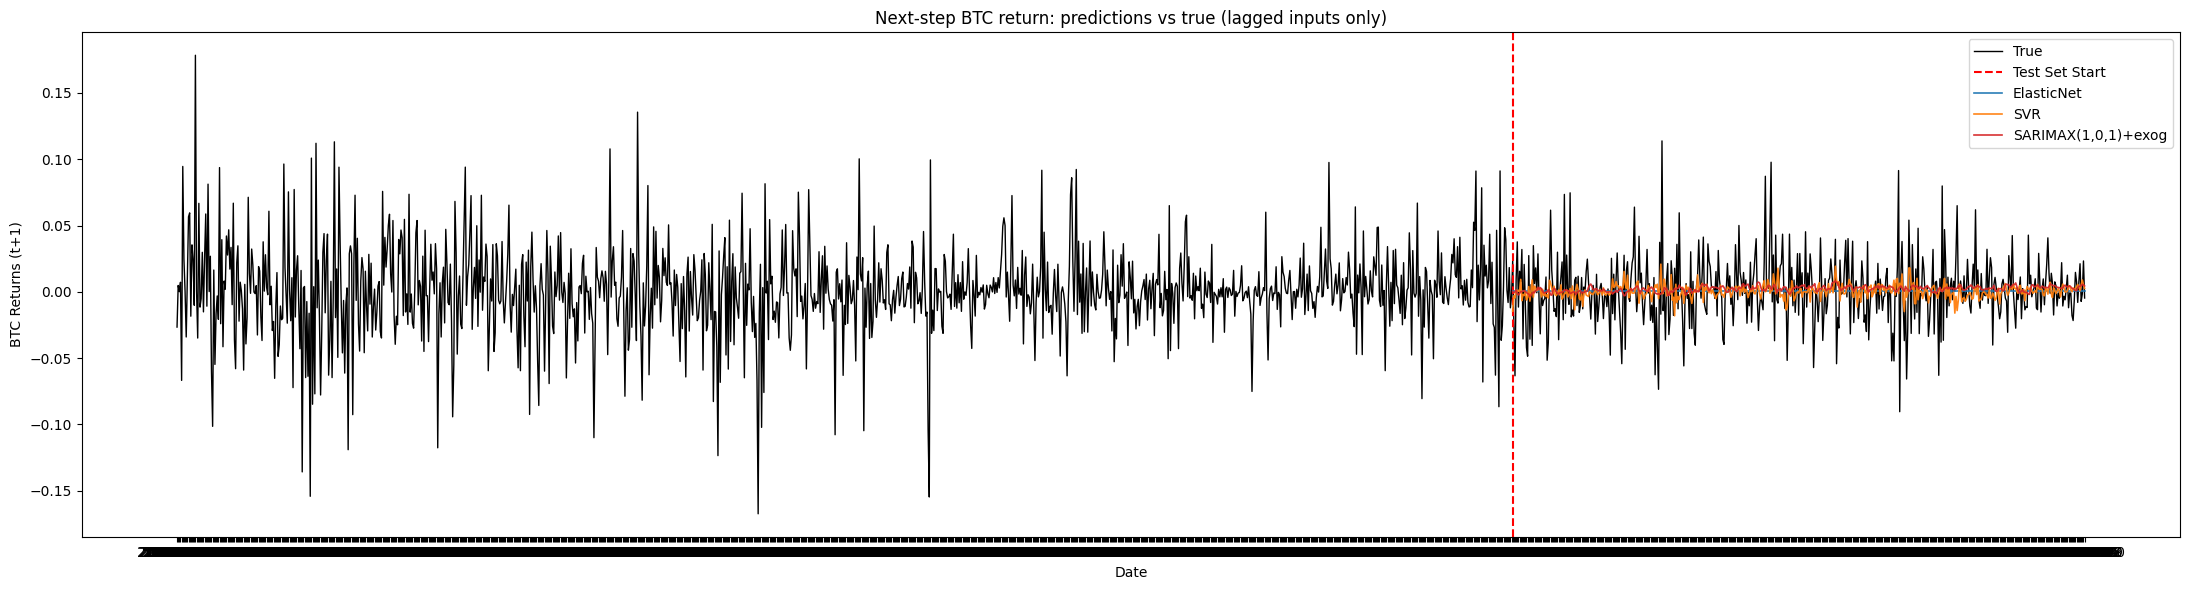

In [12]:
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

np.random.seed(42)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# ----- Metrics -----
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-8, y_true))) * 100

def thiels_u(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    num = np.sqrt(np.mean((y_true - y_pred) ** 2))
    denom = np.sqrt(np.mean(y_true ** 2)) + np.sqrt(np.mean(y_pred ** 2))
    return num / denom

def eval_metrics(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        "Thiel's U": thiels_u(y_true, y_pred),
    }

# ----- Build a forecasting dataset: y(t+1) from only info available at t -----
macro_features = ['GASREGW', 'DCOILWTICO', 'WTISPLC']
present_macros = [c for c in macro_features if c in df_merged.columns]
if len(present_macros) != len(macro_features):
    missing = [c for c in macro_features if c not in present_macros]
    print(f"Warning: missing macro features: {missing}")

df = df_merged.sort_index().copy()

# Lag all exogenous features so they are known at time t
exog_cols = present_macros + (['dominance'] if 'dominance' in df.columns else [])
for c in exog_cols:
    df[f'{c}_lag1'] = df[c].shift(1)

# Autoregressive and rolling features from returns
lags = [1, 2, 3, 5, 10]
for L in lags:
    df[f'ret_lag{L}'] = df['BTC_returns'].shift(L)

for w in [5, 20]:
    df[f'ret_mean_{w}'] = df['BTC_returns'].rolling(w).mean().shift(1)
    df[f'ret_std_{w}']  = df['BTC_returns'].rolling(w).std().shift(1)
    df[f'ret_z_{w}']    = df[f'ret_mean_{w}'] / (df[f'ret_std_{w}'] + 1e-8)

# Forecast next-period return
df['y'] = df['BTC_returns'].shift(-1)

# Assemble feature list and drop NaNs from lagging/shifting
feature_cols = [c for c in df.columns if c.startswith('ret_lag') or c.startswith('ret_mean_') or c.startswith('ret_std_') or c.startswith('ret_z_') or c.endswith('_lag1')]
dataset = df[feature_cols + ['y']].dropna().copy()

X = dataset[feature_cols]
y = dataset['y']

# Train/test split (time-ordered)
split_idx = int(len(dataset) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

results = {}
preds_test = {}

# ----- ElasticNet (robust for tiny signals) -----
tscv = TimeSeriesSplit(n_splits=5)
enet = Pipeline([
    ('scaler', StandardScaler()),
    ('enet', ElasticNetCV(l1_ratio=[0.05, 0.2, 0.5, 0.8, 0.95], alphas=np.logspace(-5, -1, 15), cv=tscv, max_iter=20000))
])
enet.fit(X_train, y_train)
y_pred_enet = enet.predict(X_test)
results['ElasticNet'] = eval_metrics(y_test.values, y_pred_enet)
preds_test['ElasticNet'] = y_pred_enet

# ----- SVR tuned on the correct scale (very small epsilon) -----
svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])
param_grid = {
    'svr__C': [1, 5, 10, 50, 100],
    'svr__epsilon': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3],
    'svr__gamma': ['scale', 'auto', 0.01, 0.1]
    
}
svr_grid = GridSearchCV(svr_pipe, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, refit=True)
svr_grid.fit(X_train, y_train)
y_pred_svr = svr_grid.predict(X_test)
results['SVR'] = eval_metrics(y_test.values, y_pred_svr)
preds_test['SVR'] = y_pred_svr
print("Best SVR parameters:", svr_grid.best_params_)

# ----- SARIMAX with exogenous lags -----
try:
    sarimax = SARIMAX(y_train, order=(1,0,1), trend='n', exog=X_train, enforce_stationarity=False, enforce_invertibility=False)
    sarimax_fit = sarimax.fit(disp=False)
    y_pred_sarimax = sarimax_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)
    results['SARIMAX(1,0,1)+exog'] = eval_metrics(y_test.values, y_pred_sarimax.values)
    preds_test['SARIMAX(1,0,1)+exog'] = y_pred_sarimax.values
except Exception as e:
    print("SARIMAX failed:", e)

# ----- Results -----
results_df = pd.DataFrame(results).T
display(results_df)

# ----- Overfit check -----
def overfit_note(model, y_tr_pred, y_ts_pred):
    print(f"{model} R2 train: {r2_score(y_train, y_tr_pred):.3f}, R2 test: {r2_score(y_test, y_ts_pred):.3f}")

try:
    overfit_note("ElasticNet", enet.predict(X_train), y_pred_enet)
except Exception:
    pass
try:
    overfit_note("SVR", svr_grid.predict(X_train), y_pred_svr)
except Exception:
    pass
try:
    overfit_note("SARIMAX", sarimax_fit.predict(start=y_train.index[0], end=y_train.index[-1], exog=X_train), y_pred_sarimax)
except Exception:
    pass

# ----- Plot -----
import matplotlib.pyplot as plt
plt.figure(figsize=(22, 6))
plt.plot(y.index, y.values, color='k', lw=1.0, label='True')
test_start_time = y_test.index[0]
plt.axvline(test_start_time, color='r', linestyle='--', lw=1.5, label='Test Set Start')

colors = {'ElasticNet': 'C0', 'SVR': 'C1', 'SARIMAX(1,0,1)+exog': 'C3'}
for name, pred in preds_test.items():
    plt.plot(y_test.index, pred, lw=1.2, label=name, color=colors.get(name, None), alpha=0.95)

plt.title('Next-step BTC return: predictions vs true (lagged inputs only)')
plt.xlabel('Date')
plt.ylabel('BTC Returns (t+1)')
plt.legend()
plt.tight_layout()
plt.show()

Why the models look like “not predicting”

- When you train on raw BTC_returns with slow, macro inputs, there’s almost no linear signal at the same timestamp. The loss-minimizing solution collapses to a constant near zero, so lines hug 0 even after calibration.
- Targets are contemporaneous, not “next step.” Without shifting the target forward and lagging inputs back, the model can’t learn a tradable mapping.
- SVR’s decision tube and the tiny scale of returns push the model to output values close to the intercept unless there’s very clear signal, which there isn’t in the current features.

## M2 GLOBAL SUPPLY AND YOY GROWTH MODEL ##

In [ ]:
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")

# ---------- Helpers ----------
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-8, y_true))) * 100

def thiels_u(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    num = np.sqrt(np.mean((y_true - y_pred) ** 2))
    denom = np.sqrt(np.mean(y_true ** 2)) + np.sqrt(np.mean(y_pred ** 2))
    return num / denom

def eval_metrics(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        "Thiel's U": thiels_u(y_true, y_pred)
    }

def forward_cum_return(r: pd.Series, horizon: int) -> pd.Series:
    arr = r.values
    out = np.full(len(arr), np.nan, dtype=float)
    for i in range(len(arr) - horizon):
        out[i] = np.prod(1.0 + arr[i+1:i+1+horizon]) - 1.0  # t -> (t+1..t+h)
    return pd.Series(out, index=r.index)

# ---------- Build macro features (M2) ----------
df = df_merged.sort_index().copy()

# Expect one/both of these columns in your merged frame:
# - 'M2_global' (level, any frequency; we'll forward-fill to daily)
# - 'M2_global_yoy' (YoY growth, already computed)
has_m2_level = 'M2_global' in df.columns
has_m2_yoy   = 'M2_global_yoy' in df.columns

if not has_m2_level and not has_m2_yoy:
    print("Missing 'M2_global'/'M2_global_yoy' in df_merged. Add one of them (level or YoY).")
    
# If M2 is not daily, forward-fill to match BTC index
if has_m2_level:
    m2 = df['M2_global'].copy()
    # If sparse (monthly/weekly), forward-fill to daily
    if m2.index.inferred_freq is None or m2.index.inferred_freq[0].upper() not in ('D',):
        m2 = m2.resample('D').last().ffill()
    df = df.join(m2.rename('M2_global'), how='left')
    has_m2_level = True

# Create YoY if only level is provided
if not has_m2_yoy and has_m2_level:
    # Year-over-year on daily index (~365 trading days)
    df['M2_global_yoy'] = df['M2_global'].pct_change(365) * 100.0
    has_m2_yoy = True

# Log-level (optional) and z-scored YoY
if has_m2_level:
    df['log_M2'] = np.log(df['M2_global']).replace([np.inf, -np.inf], np.nan)
if has_m2_yoy:
    df['M2_yoy_z'] = (df['M2_global_yoy'] - df['M2_global_yoy'].rolling(365).mean()) / (df['M2_global_yoy'].rolling(365).std() + 1e-8)

# ---------- Target: 30-day forward BTC return ----------
h = 30
if 'BTC_returns' not in df.columns:
    raise ValueError("Expected 'BTC_returns' in df_merged to compute forward returns.")
df['y_30d'] = forward_cum_return(df['BTC_returns'], horizon=h)

# ---------- Feature set ----------
feat = []

# BTC dominance (level + lags capturing slower shifts)
if 'dominance' in df.columns:
    df['dominance_lag1']  = df['dominance'].shift(1)
    df['dominance_lag7']  = df['dominance'].shift(7)
    df['dominance_lag30'] = df['dominance'].shift(30)
    feat += ['dominance_lag1', 'dominance_lag7', 'dominance_lag30']

# M2 level/YoY with macro-scale lags (~1M and ~3M)
if has_m2_level:
    df['log_M2_lag30']  = df['log_M2'].shift(30)
    df['log_M2_lag90']  = df['log_M2'].shift(90)
    feat += ['log_M2_lag30', 'log_M2_lag90']
if has_m2_yoy:
    df['M2_yoy_lag30']  = df['M2_global_yoy'].shift(30)
    df['M2_yoy_lag90']  = df['M2_global_yoy'].shift(90)
    df['M2_yoy_z_lag30'] = df['M2_yoy_z'].shift(30)
    feat += ['M2_yoy_lag30', 'M2_yoy_lag90', 'M2_yoy_z_lag30']

# Optional: include recent BTC own lags to handle residual short-memory
df['ret_lag1']  = df['BTC_returns'].shift(1)
df['ret_lag5']  = df['BTC_returns'].shift(5)
df['ret_lag20'] = df['BTC_returns'].shift(20)
feat += ['ret_lag1', 'ret_lag5', 'ret_lag20']

dataset = df[feat + ['y_30d']].dropna().copy()
X, y = dataset[feat], dataset['y_30d']

# ---------- Split ----------
split_idx = int(len(dataset) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# ---------- Models ----------
results = {}
preds_test = {}

# ElasticNet (good for weak, sparse macro signal)
tscv = TimeSeriesSplit(n_splits=5)
enet = Pipeline([
    ('scaler', StandardScaler()),
    ('enet', ElasticNetCV(
        l1_ratio=[0.05, 0.2, 0.5, 0.8, 0.95],
        alphas=np.logspace(-6, -2, 12),
        cv=tscv,
        max_iter=20000
    ))
])
enet.fit(X_train, y_train)
y_pred_enet = enet.predict(X_test)
results['ElasticNet'] = eval_metrics(y_test.values, y_pred_enet)
preds_test['ElasticNet'] = y_pred_enet

# Gradient Boosting (captures nonlinear macro effects)
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    'n_estimators': [300, 600],
    'learning_rate': [0.02, 0.05, 0.1],
    'max_depth': [2, 3],
    'subsample': [0.7, 1.0]
}
gbr_cv = GridSearchCV(gbr, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, refit=True)
gbr_cv.fit(X_train, y_train)
y_pred_gbr = gbr_cv.predict(X_test)
results['GBR'] = eval_metrics(y_test.values, y_pred_gbr)
preds_test['GBR'] = y_pred_gbr

# ---------- Results ----------
results_df = pd.DataFrame(results).T
display(results_df)

# ---------- Plot ----------
import matplotlib.pyplot as plt

plt.figure(figsize=(22, 6))
plt.plot(y.index, y.values, color='k', lw=1.0, label='True 30d fwd return')
test_start_time = y_test.index[0]
plt.axvline(test_start_time, color='r', linestyle='--', lw=1.5, label='Test Start')

plt.plot(y_test.index, preds_test['ElasticNet'], lw=1.2, label='ElasticNet', color='C0', alpha=0.95)
plt.plot(y_test.index, preds_test['GBR'],       lw=1.2, label='GBR',        color='C3', alpha=0.95)

plt.title('30-day ahead BTC return using M2 Global (level + YoY) and BTC dominance')
plt.xlabel('Date'); plt.ylabel('Forward 30d Return')
plt.legend(); plt.tight_layout(); plt.show()